# `pyqg` Subgrid Forcing Datasets

In this notebook, we'll document and showcase datasets for learning subgrid forcing parameterizations, generated with [`pyqg`](https://pyqg.readthedocs.io/en/latest/).

In [12]:
import numpy as np
import xarray as xr
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
import json

%matplotlib inline

plt.rcParams.update({'font.size': 13})

In [2]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

The datasets are organized into the following [`zarr`](https://zarr.readthedocs.io/en/stable/) files:

```
eddy/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
jet/
    high_res.zarr
    low_res.zarr
    forcing1.zarr
    forcing2.zarr
    forcing3.zarr
```

Each dataset represents a `pyqg.QGModel` simulation run for 10 years, with snapshot variables saved every 1000 hours. Daily time-averaged diagnostic variables are also stored (averages start being taken at 5 years).

## `pyqg` configurations

Before digging into the variables and the different types of datasets we present, let's describe the the top-level directories (`eddy` and `jet`). These directories represent different configurations in which we run `pyqg.QGModel` simulations. These configurations vary parameters like `beta` (slope of Coriolis parameter), `delta` (ratio of layer widths), and `rek` (strength of bottom friction). Each leads to qualitatively different behavior, as can be seen below:

In [4]:
eddy_high_res = get_dataset('eddy/high_res').isel(run=0)
jet_high_res = get_dataset('jet/high_res').isel(run=0)

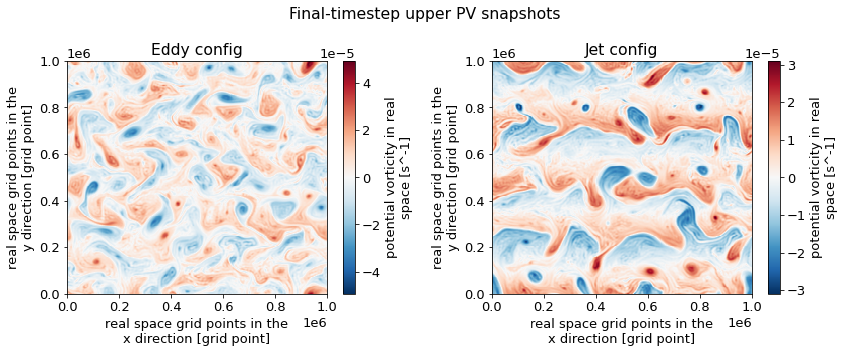

In [14]:
plt.figure(figsize=(12,5)).suptitle("Final-timestep upper PV snapshots")
plt.subplot(121); eddy_high_res.q.isel(lev=0, time=-1).plot(); plt.title("Eddy config")
plt.subplot(122);  jet_high_res.q.isel(lev=0, time=-1).plot(); plt.title( "Jet config")
plt.tight_layout()

Each dataset also stores the parameters passed to `pyqg.QGModel` which were used to generate it:

In [15]:
json.loads(eddy_high_res.attrs['pyqg_params'])

{'nx': 256.0, 'dt': 3600.0, 'tmax': 311040000.0, 'tavestart': 155520000.0}

In [16]:
json.loads(jet_high_res.attrs['pyqg_params'])

{'nx': 256.0,
 'dt': 3600.0,
 'tmax': 311040000.0,
 'tavestart': 155520000.0,
 'rek': 7e-08,
 'delta': 0.1,
 'beta': 1e-11}

In [17]:
eddy_model = pyqg.QGModel(**json.loads(eddy_high_res.attrs['pyqg_params']))
jet_model = pyqg.QGModel(**json.loads(jet_high_res.attrs['pyqg_params']))
# From here, you could call .run() to run a new simulation

INFO:  Logger initialized
INFO:  Logger initialized


## Types of datasets

Alright, so now let's discuss the structure within each configuration-specific subdirectory:

- `high_res.zarr` contains snapshots and diagnostics for high resolution eddy-resolving models (`nx=256`), where the grid length is about 4x the deformation radius.
- `low_res.zarr` contains snapshots and diagnostics for low resolution eddy-permitting models (`nx=64`), where the grid length is slightly less than the deformation radius.
- `forcing{1,2,3}.zarr` contain high resolution snapshots that have been _filtered and coarsened_ down to low resolution, along with associated _subgrid forcing_ variables. There are three of these datasets because we experiment with three different operators for filtering and coarse-graining the high-resolution potential vorticity:
    * `forcing1.zarr` uses spectral truncation followed by [the sharp spectral filter used internally by `pyqg`](https://pyqg.readthedocs.io/en/latest/equations/notation_twolayer_model.html#marching-forward)
    * `forcing2.zarr` uses spectral truncation followed by a Gaussian spectral filter, following e.g. [Guan et al. 2021](https://doi.org/10.1016/j.jcp.2022.111090)
    * `forcing3.zarr` uses [GCM-Filters](https://gcm-filters.readthedocs.io/en/latest/) to filter the PV in real space, followed by averaging and coarsening in real space.
    
These are also described in the dataset's attributes, and the operators are demonstrated in [this notebook](./subgrid_forcing.ipynb).

In [18]:
# Load a small subset of the subgrid forcing data,
# computed with Operator 1 (spectral truncation + sharp filter)
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
eddy_forcing2 = get_dataset('eddy/forcing2').isel(run=0).load()

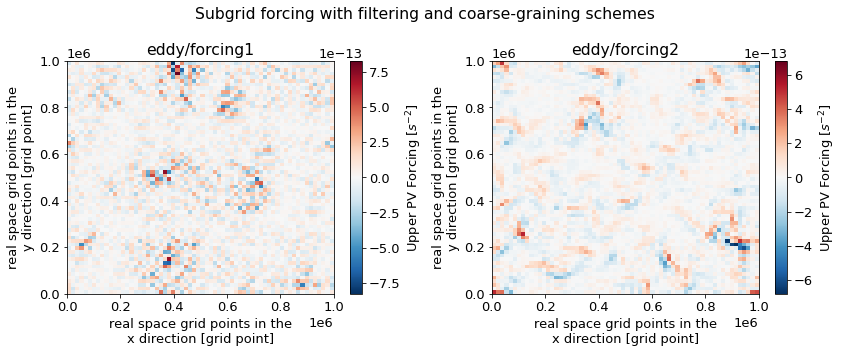

In [25]:
plt.figure(figsize=(12,5)).suptitle("Subgrid forcing with filtering and coarse-graining schemes")
plt.subplot(121); eddy_forcing1.q_subgrid_forcing.isel(lev=1, time=-1).plot(
    cbar_kwargs=dict(label="Upper PV Forcing [$s^{-2}$]"))
plt.title("eddy/forcing1")
plt.subplot(122); eddy_forcing2.q_subgrid_forcing.isel(lev=1, time=-1).plot(
    cbar_kwargs=dict(label="Upper PV Forcing [$s^{-2}$]"))
plt.title("eddy/forcing2")
plt.tight_layout()

## Variables stored

### State variables 

Each dataset stores a large number of variables. These include the following state variables:

- `q`: Potential vorcitity
- `u`: $x$-velocity relative to the background flow
- `v`: $y$-velocity relative to the background flow
- `ufull` and `vfull` - corresponding variables but including the background flow
- `streamfunction`

### Forcing variables

For the forcing datasets (`forcing{1,2,3}.zarr`), we include the following additional variables describing discrepancies between the high-resolution model and its coarsened counterpart (where $\overline{(\,)}$ denotes the coarse-graining operator):

- `q_subgrid_forcing`: $S_q \equiv \overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$
- `u_subgrid_forcing`: $S_u \equiv \overline{(\mathbf{u} \cdot \nabla)u} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{u}$
- `v_subgrid_forcing`: $S_v \equiv \overline{(\mathbf{u} \cdot \nabla)v} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{v}$
- `uq_subgrid_flux`: $\phi_{uq} \equiv \overline{uq} - \bar{u}\bar{q}$
- `vq_subgrid_flux`: $\phi_{vq} \equiv \overline{vq} - \bar{v}\bar{q}$. Note that $\nabla \cdot \langle\phi_{uq}, \phi_{vq}\rangle = S_q$.
- `uu_subgrid_flux`: $\phi_{uu} \equiv \overline{u^2} - \bar{u}^2$
- `vv_subgrid_flux`: $\phi_{vv} \equiv \overline{v^2} - \bar{v}^2$
- `uv_subgrid_flux`: $\phi_{uv} \equiv \overline{uv} - \bar{u}\bar{v}$. Note that $\nabla \cdot \langle\phi_{uu}, \phi_{uv}\rangle = S_u$ and $\nabla \cdot \langle\phi_{uv}, \phi_{vv}\rangle = S_v$.
- `dqdt_bar`: PV tendency from the high-resolution model, filtered and coarsened to low resolution
- `dqbar_dt`: PV tendency from the low-resolution model, initialized at $\overline{q}$. Note that `dqdt_bar - dqbar_dt` can be an alternative prediction target to `q_subgrid_forcing` (it's very similar, except it also accounts for numerical dissipation).

One use-case for these datasets is to learn data-driven parameterizations which predict certain of these forcing variables (either $S_q$, both $S_u$ and $S_v$, or an equivalent flux term) from the resolved low-resolution state variables.

### Diagnostic variables

We include a number of diagnostic variables to help measure how quantities like energy and enstrophy are distributed and transferred across scales. These make most sense to plot for the high- and low-resolution reference simulations (or for parameterized simulations), rather than for the forcing datasets (though they are still included).

**Power spectra:**
- `KEspec`: how much kinetic energy is stored at each $x$ and $y$ lengthscale
- `Ensspec`: how much enstrophy is stored at each $x$ and $y$ lengthscale

**Energy budget (should sum to 0):**
- `KEflux`: how kinetic energy is being transferred across lengthscales
- `APEflux`: how available potential energy is being transferred across lengthscales
- `APEgenspec`: how much new available potential energy is being generated at each scale
- `KEfrictionspec`: how much energy is being lost to bottom drag at each lengthscale
- `Dissspec`: how much energy is being lost due to numerical dissipation at each lengthscale

**Enstrophy budget (should sum to 0):**
- `ENSflux`: how enstrophy is being transferred across lengthscales
- `ENSgenspec`: how much new enstrophy is being generated
- `ENSfrictionspec`: how much enstrophy is lost to bottom drag
- `ENSDissspec`: how much enstrophy is lost to numerical dissipation

These can be plotted, e.g. as follows:

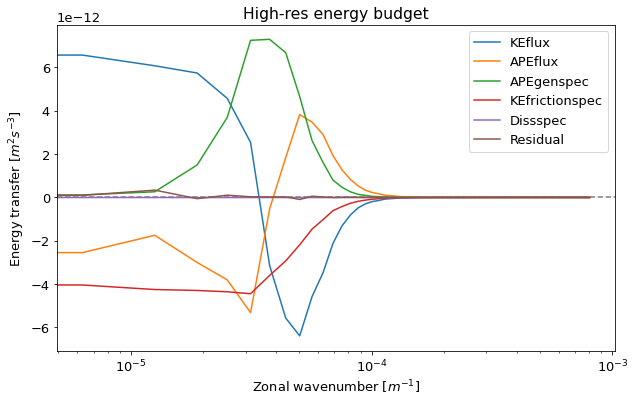

In [42]:
energy_budget = ['KEflux','APEflux','APEgenspec','KEfrictionspec','Dissspec']
plt.figure(figsize=(10,6))
plt.title("High-res energy budget")
plt.axhline(0,color='gray', ls='--')
for term in energy_budget:
    plt.semilogx(eddy_high_res.k, eddy_high_res[term].sum('l'), label=term) 
plt.semilogx(eddy_high_res.k, np.sum([eddy_high_res[t].sum('l') for t in energy_budget], axis=0), label='Residual')
plt.legend()
plt.ylabel("Energy transfer $[m^2 s^{-3}]$")
plt.xlabel("Zonal wavenumber $[m^{-1}]$")
plt.show()

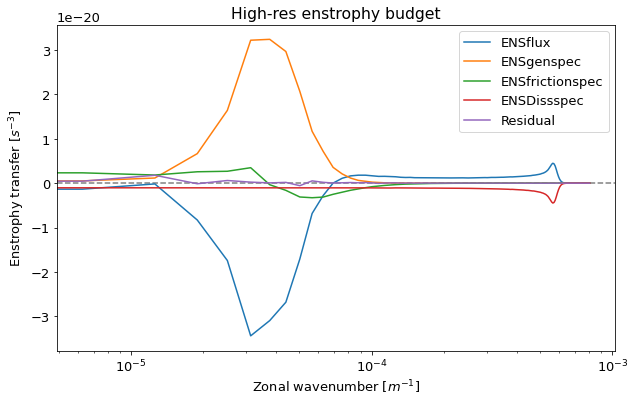

In [41]:
enstrophy_budget = ['ENSflux','ENSgenspec','ENSfrictionspec','ENSDissspec']
plt.figure(figsize=(10,6))
plt.title("High-res enstrophy budget")
plt.axhline(0,color='gray', ls='--')
for term in enstrophy_budget:
    plt.semilogx(eddy_high_res.k, eddy_high_res[term].sum('l'), label=term) 
plt.semilogx(eddy_high_res.k, np.sum([eddy_high_res[t].sum('l') for t in enstrophy_budget], axis=0), label='Residual')
plt.legend()
plt.ylabel("Enstrophy transfer $[s^{-3}]$")
plt.xlabel("Zonal wavenumber $[m^{-1}]$")
plt.show()

The `xarray.Dataset` objects themselves also contain some documentation for each variable:

In [43]:
eddy_forcing1

<xarray.Dataset>
Dimensions:            (l: 64, k: 33, lev: 2, time: 87, y: 64, x: 64, lev_mid: 1)
Coordinates:
  * k                  (k) float32 0.0 6.283e-06 ... 0.0001948 0.0002011
  * l                  (l) float32 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int32 1 2
  * lev_mid            (lev_mid) float32 1.5
  * time               (time) float32 0.0 3.6e+06 7.2e+06 ... 3.06e+08 3.096e+08
  * x                  (x) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float32 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables: (12/36)
    APEflux            (l, k) float32 -0.0 8.36e-15 ... 3.116e-27 -4.992e-33
    APEgen             float32 7.488e-11
    APEgenspec         (l, k) float32 0.0 -2.465e-15 ... 1.682e-38 -0.0
    Dissspec           (l, k) float32 -0.0 -0.0 -0.0 ... -2.671e-26 -8.976e-32
    EKE                (lev) float32 0.002634 8.083e-05
    EKEdiss            float32 7.484e-11
    ...                 ...
    uv_subgrid_flux    (time, lev, y, x) float32 2.313e-09 ... -5.764e-06
    v                  (time, lev, y, x) float32 -0.001655 ... -0.005067
    v_subgrid_forcing  (time, lev, y, x) float32 -7.855e-13 ... 1.62e-10
    vfull              (time, lev, y, x) float32 -0.001655 ... -0.005067
    vq_subgrid_flux    (time, lev, y, x) float32 9.977e-11 ... 5.031e-10
    vv_subgrid_flux    (time, lev, y, x) float32 -1.337e-06 ... 3.477e-06
Attributes: (12/26)
    hires:           256
    lores:           64
    pyqg:L:          1000000.0
    pyqg:M:          4096
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       311040000.0
    pyqg:twrite:     1000.0
    pyqg_params:     {"nx": 64, "dt": 3600.0, "tmax": 311040000.0, "tavestart...
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           Subgrid forcing dataset generated by coarsening nx=256 p...